In [1]:
import os
import numpy as np
import cartopy.crs as ccrs
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from matplotlib.colors import CSS4_COLORS

In [2]:
def get_unique_non_masked_values(values):
    result = []
    for value in np.unique(values):
        if value is not np.ma.masked and not np.isnan(value):
            result.append(value)
    return result

def is_whiteish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return (r + g + b) / 3 > 230  # Check if the average is above the threshold

def is_grayish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    deviation = max(r, g, b) - min(r, g, b)
    return deviation <= 20

def is_blueish(color):
    r, g, b = [int(color[i:i+2], 16) for i in (1, 3, 5)]  # Convert hex to RGB
    return  b - r > 120 and b - g > 120  # If blue is dominant and significantly larger

def get_filtered_colors(all_colors):
    result = []
    for color in all_colors:
        if color != '#00FFFF' and not is_whiteish(color) and not is_grayish(color) and not is_blueish(color):
            result.append(color)
    return result

def make_cmap(Rivnum_masked_array):
    # ユニークな流域の数をカウント
    unique_values = get_unique_non_masked_values(Rivnum_masked_array)
    num_colors = len(unique_values)

    # 流域に固有の色を割り振る
    all_colors = list(CSS4_COLORS.values())
    filtered_colors = get_filtered_colors(all_colors)
    colors_list = filtered_colors[:num_colors]

    # -1<=x<0に透明色を追加
    colors_list.insert(0, '#00000000')

    # HTMLカラーコードに変化してlisted colormap を作成
    cmap = ListedColormap(colors_list)

    # [辞書作る] key=流域ID, value=0から数えたindex　
    index_dict = {}
    for i, value in enumerate(unique_values):
        index_dict[value] = i

    return num_colors, index_dict, cmap

def get_index(val, index_dict):
    return index_dict.get(val, -1) # nan or unexpected values are mapped to -1

"""
to show the result

num_colors, index_dict, cmap = make_cmap(rivnum_region_removed)
indexed_data = np.vectorize(get_index)(rivnum_region_removed, index_dict)
im = ax.imshow(indexed_data, extent=img_extent, transform=projection,
               vmin=-1, vmax=num_colors, cmap=cmap)

The code above is required to add
"""

def draw_mask_sotowaku(extent, mask_cropped, ax=None, sotowaku_color='#dc143c', linewidth=3):
    """
    zorder = 0: デフォルトの最背面(gridをzorder=0に設定)
    zorder = 1: 赤色の外枠(citymask)
    zorder = 2: 白色の内枠が最前面(citymask)
    """

    # delta
    delta = 360/4320
    x_left = extent[0]
    y_top = extent[3]
    
    # outer
    upper_indices = []
    lower_indices = []
    left_indices = []
    right_indices = []
    rows, cols = mask_cropped.shape
    for i in range(rows):
        for j in range(cols):
            if mask_cropped[i, j] == 1:
                if mask_cropped[i-1, j] == 0:
                    upper_indices.append((i, j))
                if mask_cropped[i+1, j] == 0:
                    lower_indices.append((i, j))
                if mask_cropped[i, j-1] == 0:
                    left_indices.append((i, j))
                if mask_cropped[i, j+1] == 0:
                    right_indices.append((i, j))

    # extent
    projection = ccrs.PlateCarree()

    if ax is None:
        # figure
        fig = plt.figure()
        ax = plt.subplot(projection=projection)
        ax.coastlines(zorder=1)
        ax.set_extent(extent)
        ax.gridlines(draw_labels=True, zorder=0)
        ax.add_feature(cfea.OCEAN, color='#BBBBBB')
        ax.add_feature(cfea.LAKES, color='#BBBBBB')
        
    # city mask
    for up in upper_indices:
        x_index = x_left + delta*(up[1])
        y_index = y_top - delta*(up[0])
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # top
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # top
    for lo in lower_indices:
        x_index = x_left + delta*(lo[1])
        y_index = y_top - delta*(lo[0]+1)
        ax.plot([x_index, x_index+delta], [y_index, y_index], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # bottom
        ax.plot([x_index, x_index+delta], [y_index, y_index], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # bottom
    for le in left_indices:
        x_index = x_left + delta*(le[1])
        y_index = y_top - delta*(le[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # left
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # left
    for ri in right_indices:
        x_index = x_left + delta*(ri[1]+1)
        y_index = y_top - delta*(ri[0]+1)
        ax.plot([x_index, x_index], [y_index, y_index+delta], color=sotowaku_color, transform=projection, linewidth=linewidth, zorder=1) # right
        ax.plot([x_index, x_index], [y_index, y_index+delta], color='white', transform=projection, linewidth=linewidth-2, zorder=2) # right

    return ax

In [10]:
#
tag = '.sy5'
city_num = 80
#
resolution = 12
#
SUF = '.gl5'
dtype = 'float32'
gl5shape = (2160, 4320)
#
left = 149
right = 152
bottom = -36
top = -32
#
nx, ny = (right - left)*resolution, (top - bottom)*resolution
rgnshape = (ny, nx)
img_extent = (left, right, bottom, top)
#
upperindex = (90-top)*resolution
lowerindex = (90-bottom)*resolution
leftindex = (180+left)*resolution
rightindex = (180+right)*resolution
#
loaddir = '/mnt/c/Users/tsimk/Downloads/dotfiles/h08/global_city'
savedir = f"/mnt/c/Users/tsimk/Downloads/dotfiles/h08/region"
#
rivnum_path = f"{loaddir}/dat/riv_num_/rivnum.CAMA{SUF}"
maskpath = f"{loaddir}/dat/lnd_msk_/lndmask.CAMA{SUF}"
#
ctymsk_path =f"/mnt/c/Users/tsimk/downloads/dotfiles/h08/camacity/dat/cty_msk_/city_clrd0000{SUF}"
ctymsk = np.fromfile(ctymsk_path, dtype='float32').reshape(gl5shape)
citymask = np.where(ctymsk==city_num, 1, 0)
#
aqd_path =f"/mnt/c/Users/tsimk/downloads/dotfiles/h08/camacity/dat/cty_aqd_/100km_elevation/city_{city_num:08}{SUF}"
aqd = np.fromfile(aqd_path, dtype='float32').reshape(gl5shape)

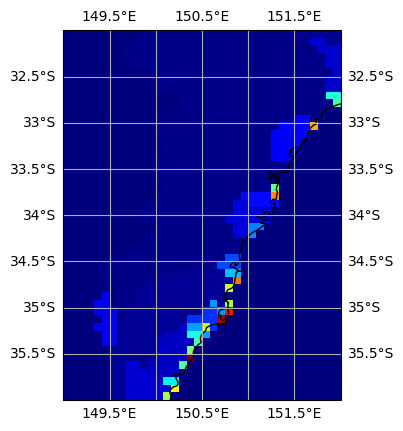

In [11]:
#
rivnum = np.fromfile(rivnum_path, dtype=dtype)
rivnum_lonlat = rivnum.reshape(gl5shape)
rivnum_cropped = rivnum_lonlat[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
#
projection = ccrs.PlateCarree(central_longitude=0)
img_extent = (left, right, bottom, top)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(rivnum_cropped, extent=img_extent, transform=projection, cmap='jet')

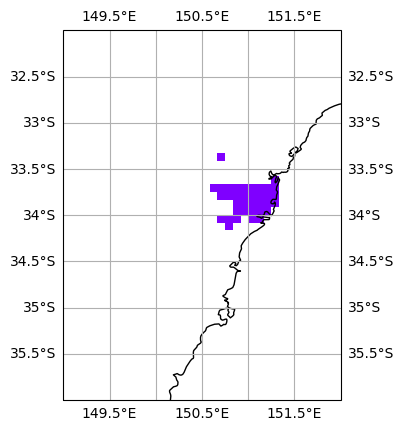

In [12]:
#
ctymsk = np.fromfile(ctymsk_path, dtype='float32').reshape(gl5shape)
citymask = np.where(ctymsk==city_num, 1, 0)
citymask_cropped = citymask[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
#
aqd = np.fromfile(aqd_path, dtype='float32').reshape(gl5shape)
aqd_cropped = aqd[int(upperindex):int(lowerindex), int(leftindex):int(rightindex)]
#
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(np.ma.masked_where(citymask_cropped==0, citymask_cropped), extent=img_extent, transform=projection, cmap='rainbow')
im2 = ax.imshow(np.ma.masked_where(aqd_cropped==0, aqd_cropped), extent=img_extent, transform=projection, cmap='rainbow')

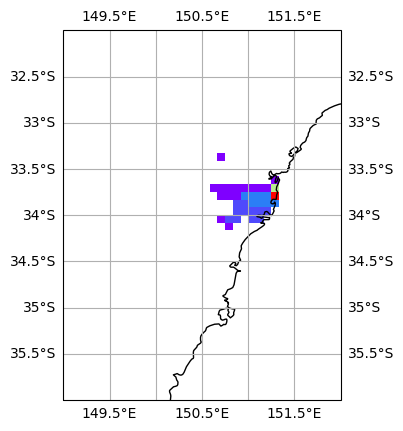

In [13]:
rivnum_region = np.where((citymask_cropped == 1) | (aqd_cropped == 1), rivnum_cropped, np.nan)
rivnum_region = np.ma.masked_where(~np.isfinite(rivnum_region) |  (rivnum_region == 0), rivnum_region)
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(rivnum_region, extent=img_extent, transform=projection, cmap='rainbow')

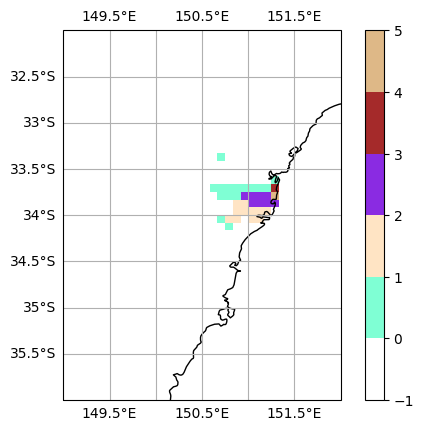

In [14]:
# no remove
remove_basin_grid_threshold = 1
#
rivnum_cropped_masked = np.ma.masked_array(rivnum_cropped, np.isnan(rivnum_cropped))
unique_values, counts = np.unique(rivnum_cropped_masked.compressed(), return_counts=True)
value_counts_dict = dict(zip(unique_values, counts))
sorted_dict_by_value_descending = dict(sorted(value_counts_dict.items(), key=lambda item: item[1], reverse=True))
filtered_dict = {key: value for key, value in sorted_dict_by_value_descending.items() if value >= remove_basin_grid_threshold}
#
rivnum_region_removed = np.ma.masked_all(rivnum_cropped.shape, dtype=dtype)
for rivnum_id in filtered_dict.keys():
    matching_positions = np.where(rivnum_region.data == rivnum_id)
    rivnum_region_removed[matching_positions] = rivnum_id
#
rivnum_region_removed = np.ma.masked_where(~np.isfinite(rivnum_region_removed) | (rivnum_region_removed == 0), rivnum_region_removed)
#
num_colors, index_dict, cmap = make_cmap(rivnum_region_removed)
indexed_data = np.vectorize(get_index)(rivnum_region_removed, index_dict)
#
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
gl = ax.gridlines(draw_labels=True)
gl.right_labels = False
im = ax.imshow(indexed_data, extent=img_extent, transform=projection,
               vmin=-1, vmax=num_colors, cmap=cmap)
fig.colorbar(im, ax=ax, orientation='vertical')

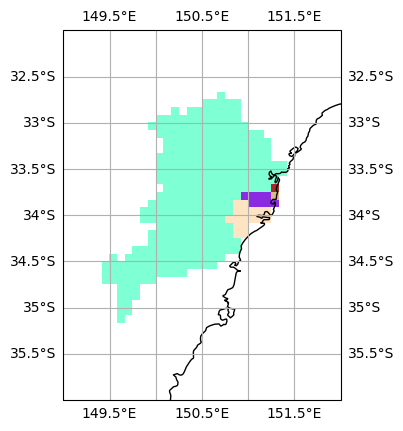

In [15]:
#
unique_ids = np.unique(rivnum_region_removed.compressed())
rivnum_unique = np.ma.masked_all(rivnum_cropped_masked.shape, dtype='float32')
for uid in unique_ids:
    row_indices, col_indices = np.where(rivnum_cropped == uid)
    rivnum_unique[row_indices, col_indices] = uid
#
indexed_rivnum_unique = np.vectorize(get_index)(rivnum_unique, index_dict)
#
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(indexed_rivnum_unique, extent=img_extent, transform=projection,
               vmin=-1, vmax=num_colors, cmap=cmap)

<GeoAxes: >

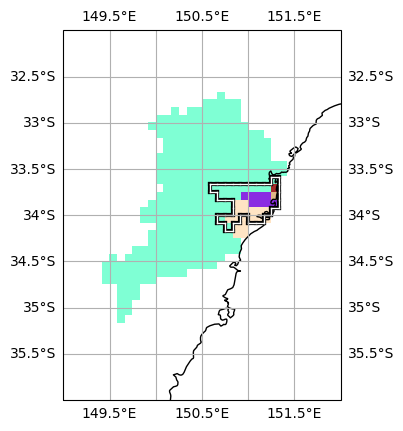

In [16]:
fig = plt.figure()
ax = plt.subplot(projection=projection)
ax.coastlines()
ax.gridlines(draw_labels=True)
im = ax.imshow(indexed_rivnum_unique, extent=img_extent, transform=projection,
               vmin=-1, vmax=num_colors, cmap=cmap)
#msk = ax.contour(citymask_cropped, levels=[0.5], colors='#333333', linewidths=3, origin='upper', extent=img_extent, transform=projection, zorder=10)
draw_mask_sotowaku(img_extent, citymask_cropped, ax=ax, sotowaku_color='black')

(48, 36)
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]


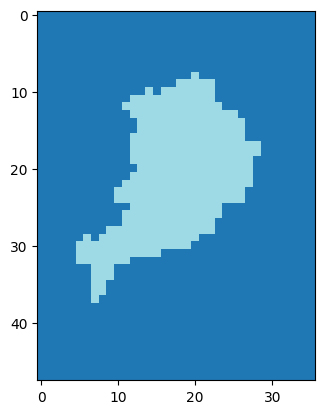

In [17]:
# 0-1 binary land mask file for only 5basins
rivnum_unique_filled = rivnum_unique.filled(0)
landmask = np.where(rivnum_unique_filled > 0, 1, 0)
print(landmask.shape)
print(landmask[0])
plt.imshow(landmask, cmap='tab20')

In [18]:
# save the file
save_flag = True
if save_flag is True:
    save_path = f"{savedir}/dat/lnd_msk_/lndmsk.CAMA{tag}"
    landmask.astype(np.float32).tofile(save_path)
    print(f"{save_path} is saved")

/mnt/c/Users/tsimk/Downloads/dotfiles/h08/region/dat/lnd_msk_/lndmsk.CAMA.sy5 is saved
